In [17]:
import tensorflow as tf
import os
import time
from abc import ABC, abstractmethod
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
import pickle
import warnings

## Agents

In [18]:
class BaseAgent(ABC):
    """
    The base class for all agents.

    Methods:
    - build_model(self): Abstract method to build the model architecture.
    - act(self, instrument_paths, T_minus_t): Abstract method to act based on inputs.
    - transform_input(self, *args): Optional method to transform inputs if necessary.
    """

    @abstractmethod
    def build_model(self):
        pass

    @abstractmethod
    def act(self, instrument_paths, T_minus_t):
        pass

    def transform_input(self, *args):
        return args 

    def transform_paths(self, instrument_paths, transformation_type=None, K=None):
        """
        Transforms the instrument paths based on the specified transformation type.

        Arguments:
        - instrument_paths (tf.Tensor): The paths of the instrument.
        - transformation_type (str, optional): The type of transformation ('log', 'log_moneyness'). Default is None.
        - K (float, optional): The strike price, required if transformation_type is 'log_moneyness'.

        Returns:
        - transformed_paths (tf.Tensor): The transformed instrument paths.
        """

        if transformation_type is None:
            # No transformation, return the paths as-is
            return instrument_paths

        elif transformation_type == 'log':
            # Apply log transformation
            return tf.math.log(instrument_paths)

        elif transformation_type == 'log_moneyness':
            if K is None:
                raise ValueError("Strike price K must be provided for 'log moneyness' transformation.")
            return tf.math.log(instrument_paths / K)

        else:
            raise ValueError(f"Unsupported transformation type: {transformation_type}")


In [19]:
class DeltaHedgingAgent(BaseAgent):
    """
    A delta hedging agent that computes the delta of an option and uses it as the hedging strategy.

    Arguments:
    - gbm_stock (GBMStock): An instance of the GBMStock class containing the stock parameters.
    - strike (float): Strike price of the option.
    - option_type (str): Type of the option ('call' or 'put').
    """

    def __init__(self, gbm_stock, option_class):
        self.S0 = gbm_stock.S0
        self.T = gbm_stock.T
        self.N = gbm_stock.N
        self.r = gbm_stock.r
        self.sigma = gbm_stock.sigma
        self.strike = option_class.strike
        self.option_type = option_class.option_type
        self.dt = gbm_stock.dt
        self.name = 'delta_hedging'

    def build_model(self):
        """
        Dummy implementation as no model building is required for delta hedging.
        """
        pass

    def d1(self, S, T_minus_t):
        """
        Calculate the d1 component used in the Black-Scholes formula.

        Arguments:
        - S (tf.Tensor): The current stock price.
        - T_minus_t (tf.Tensor): The current T - t.

        Returns:
        - d1 (tf.Tensor): The d1 value.
        """

        eps = 1e-4
        return (tf.math.log(S / self.strike) + (self.r + 0.5 * self.sigma ** 2) * (T_minus_t + eps)) / (self.sigma * tf.sqrt(T_minus_t + eps))

    def delta(self, S, T_minus_t):
        """
        Calculate the delta of the option.

        Arguments:
        - S (tf.Tensor): The current stock price.
        - t (tf.Tensor): The current time.

        Returns:
        - delta (tf.Tensor): The delta value.
        """
        d1 = self.d1(S, T_minus_t)
        normal_dist = tfp.distributions.Normal(loc=0.0, scale=1.0)
        if self.option_type == 'call':
            return normal_dist.cdf(d1)
        elif self.option_type == 'put':
            return normal_dist.cdf(d1) - 1.0
        else:
            raise ValueError("Option type must be either 'call' or 'put'.")

    def act(self, instrument_paths, T_minus_t):
        """
        Act based on the delta hedging strategy.

        Arguments:
        - instrument_paths (tf.Tensor): Tensor containing the instrument paths at the current timestep.
        - T_minus_t (tf.Tensor): Tensor representing the time to maturity at the current timestep.

        Returns:
        - action (tf.Tensor): The delta value used as the hedging action.
        """

        delta = self.delta(instrument_paths, T_minus_t)
        action = delta - self.last_delta
        self.last_delta = delta

        return tf.expand_dims(action, axis=-1)

    def reset_last_delta(self, batch_size):
        self.last_delta = tf.zeros((batch_size,), dtype=tf.float32)

    def process_batch(self, batch_paths, batch_T_minus_t):
        self.reset_last_delta(batch_paths.shape[0])
        all_actions = []
        for t in range(batch_paths.shape[1] -1):  # timesteps until T-1
            current_paths = batch_paths[:, t]
            current_T_minus_t = batch_T_minus_t[:, t]
            action = self.act(current_paths, current_T_minus_t)
            all_actions.append(action)

        all_actions = tf.concat(all_actions, axis=1)
        zero_action = tf.zeros((batch_paths.shape[0], 1))
        all_actions = tf.concat([all_actions, zero_action], axis=1)

        return all_actions

    def get_model_price(self):
        """
        Calculate the Black-Scholes price for the option.

        Returns:
        - price (tf.Tensor): The Black-Scholes price of the option.
        """
        d1 = self.d1(self.S0, self.T)
        d2 = d1 - self.sigma * tf.sqrt(self.T)
        
        normal_dist = tfp.distributions.Normal(loc=0.0, scale=1.0)
        if self.option_type == 'call':
            price = (self.S0 * normal_dist.cdf(d1) - 
                     self.strike * tf.exp(-self.r * self.T) * normal_dist.cdf(d2))
        elif self.option_type == 'put':
            price = (self.strike * tf.exp(-self.r * self.T) * normal_dist.cdf(-d2) - 
                     self.S0 * normal_dist.cdf(-d1))
        else:
            raise ValueError("Option type must be either 'call' or 'put'.")
        
        return price

In [20]:
class LSTMAgent(BaseAgent):
    """
    An LSTM agent that processes the entire sequence of inputs at once.

    Arguments:
    - input_shape (tuple): Shape of the input.
    - output_shape (int): Shape of the output.
    """

    def __init__(self, n_hedging_timesteps, path_transformation_type = None, K = None):
        input_shape = (n_hedging_timesteps, 2)
        output_shape = 1
        self.model = self.build_model(input_shape, output_shape)
        self.name = 'lstm'
        self.path_transformation_type = path_transformation_type
        self.K = K

    def build_model(self, input_shape, output_shape):
        """
        Builds an LSTM model.

        Arguments:
        - input_shape (tuple): Shape of the input.
        - output_shape (int): Shape of the output.

        Returns:
        - model (tf.keras.Model): The built model.
        """
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dense(output_shape, activation='linear')
        ])
        return model


    def transform_input(self, instrument_paths, T_minus_t):
        """
        Transforms the input by concatenating instrument paths and time to maturity.

        Arguments:
        - instrument_paths (tf.Tensor): Tensor containing the instrument paths at the current timestep.
                                        Shape: (batch_size, input_shape)
        - T_minus_t (tf.Tensor): Tensor representing the time to maturity at the current timestep.
                                Shape: (batch_size,)

        Returns:
        - input_data (tf.Tensor): The transformed input data.
                                Shape: (batch_size, input_shape + 1)
        """
        instrument_paths = self.transform_paths(instrument_paths, self.path_transformation_type, K = self.K)

        # Ensure both tensors have the same rank by expanding dimensions of instrument_paths
        instrument_paths = tf.expand_dims(instrument_paths, axis=-1)  # Shape: (batch_size, input_shape, 1)
        T_minus_t = tf.expand_dims(T_minus_t, axis=-1)  # Shape: (batch_size, 1)
        
        # Concatenate along the last axis
        input_data = tf.concat([instrument_paths, T_minus_t], axis=-1)  # Shape: (batch_size, input_shape + 1)
        return input_data
    



    def act(self, instrument_paths, T_minus_t):
        """
        Act based on the entire sequence of inputs.

        Arguments:
        - instrument_paths (tf.Tensor): Tensor containing the instrument paths for all timesteps.
        - T_minus_t (tf.Tensor): Tensor representing the time to maturity for all timesteps.

        Returns:
        - actions (tf.Tensor): The actions chosen by the model.
        """
        input_data = self.transform_input(instrument_paths, T_minus_t)
        actions = self.model(input_data)
        return actions

    def process_batch(self, batch_paths, batch_T_minus_t):

        all_actions = self.act(batch_paths[:, :-1], batch_T_minus_t)

        zero_action = tf.zeros((batch_paths.shape[0], 1, all_actions.shape[2]))
        all_actions = tf.concat([all_actions, zero_action], axis=1)
        all_actions = all_actions[:, :, 0] # temporary, only one instrument

        return all_actions


    def train_batch(self, batch_paths, batch_T_minus_t, optimizer, loss_function):
        """
        Train the model on a batch of data using the entire sequence at once.

        Arguments:
        - batch_paths (tf.Tensor): Tensor containing a batch of instrument paths. Shape: (batch_size, timesteps, input_shape)
        - batch_T_minus_t (tf.Tensor): Tensor containing the time to maturity at each timestep.
        - optimizer (tf.optimizers.Optimizer): The optimizer to use for training.

        Returns:
        - loss (tf.Tensor): The loss value after training on the batch.
        """
        with tf.GradientTape() as tape:
            actions = self.process_batch(batch_paths, batch_T_minus_t)
            loss = loss_function(batch_paths, actions) 
            # Compute gradients based on the loss
            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss
    


In [21]:
class SimpleAgent(BaseAgent):
    """
    A simple agent that processes inputs timestep by timestep.

    Arguments:
    - input_shape (tuple): Shape of the input.
    - output_shape (int): Shape of the output.
    """

    def __init__(self, path_transformation_type = None, K = None):
        input_shape = (2,)
        output_shape = 1
        self.model = self.build_model(input_shape, output_shape)
        self.name = 'simple'
        self.path_transformation_type = path_transformation_type
        self.K = K

    def build_model(self, input_shape, output_shape):
        """
        Builds a simple feedforward model.

        Arguments:
        - input_shape (tuple): Shape of the input.
        - output_shape (int): Shape of the output.

        Returns:
        - model (tf.keras.Model): The built model.
        """
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(output_shape, activation='linear')
        ])
        return model

    def transform_input(self, instrument_paths, T_minus_t):
        """
        Transforms the input by concatenating instrument paths and time to maturity.

        Arguments:
        - instrument_paths (tf.Tensor): Tensor containing the instrument paths at the current timestep.
                                        Shape: (batch_size, input_shape)
        - T_minus_t (tf.Tensor): Tensor representing the time to maturity at the current timestep.
                                Shape: (batch_size,)

        Returns:
        - input_data (tf.Tensor): The transformed input data.
                                Shape: (batch_size, input_shape + 1)
        """
        instrument_paths = self.transform_paths(instrument_paths, self.path_transformation_type, K = self.K)

        # Ensure both tensors have the same rank by expanding dimensions of instrument_paths
        instrument_paths = tf.expand_dims(instrument_paths, axis=-1)  # Shape: (batch_size, input_shape, 1)
        T_minus_t = tf.expand_dims(T_minus_t, axis=-1)  # Shape: (batch_size, 1)
        
        # Concatenate along the last axis
        input_data = tf.concat([instrument_paths, T_minus_t], axis=-1)  # Shape: (batch_size, input_shape + 1)
        return input_data
    
    def act(self, instrument_paths, T_minus_t):
        """
        Act based on the input.

        Arguments:
        - instrument_paths (tf.Tensor): Tensor containing the instrument paths at the current timestep.
        - T_minus_t (tf.Tensor): Tensor representing the time to maturity at the current timestep.

        Returns:
        - action (tf.Tensor): The action chosen by the model.
        """
        input_data = self.transform_input(instrument_paths, T_minus_t)
        action = self.model(input_data)
        return action


    def process_batch(self, batch_paths, batch_T_minus_t):
        all_actions = []
        for t in range(batch_paths.shape[1] -1):  # timesteps until T-1
            current_paths = batch_paths[:, t]
            current_T_minus_t = batch_T_minus_t[:, t]
            action = self.act(current_paths, current_T_minus_t)
            all_actions.append(action)

        all_actions = tf.concat(all_actions, axis=1)
        zero_action = tf.zeros((batch_paths.shape[0], 1))
        all_actions = tf.concat([all_actions, zero_action], axis=1)

        return all_actions

    def train_batch(self, batch_paths, batch_T_minus_t, optimizer, loss_function):
        """
        Train the model on a batch of data, processing timestep by timestep.

        Arguments:
        - batch_paths (tf.Tensor): Tensor containing a batch of instrument paths. Shape: (batch_size, timesteps, input_shape)
        - batch_T_minus_t (tf.Tensor): Tensor containing the time to maturity at each timestep.
        - optimizer (tf.optimizers.Optimizer): The optimizer to use for training.

        Returns:
        - loss (tf.Tensor): The loss value after training on the batch.
        """
        with tf.GradientTape() as tape:
            actions = self.process_batch(batch_paths, batch_T_minus_t) 
            loss = loss_function(batch_paths, actions)

            # Compute gradients based on the total loss
            grads = tape.gradient(loss, self.model.trainable_variables)
            optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

        return loss


In [22]:
class RecurrentAgent(SimpleAgent):
    """
    A recurrent agent that processes inputs timestep by timestep and includes the accumulated position.

    Arguments:
    - input_shape (tuple): Shape of the input.
    - output_shape (int): Shape of the output.
    """

    def __init__(self, path_transformation_type = None, K = None):
        input_shape = (3,)
        output_shape = 1
        self.model = self.build_model(input_shape, output_shape)
        self.accumulated_position = None  # Initialize accumulated position
        self.name = 'recurrent'
        self.path_transformation_type = path_transformation_type
        self.K = K

    def build_model(self, input_shape, output_shape):
        """
        Builds a feedforward model with additional input for accumulated position.

        Arguments:
        - input_shape (tuple): Shape of the input.
        - output_shape (int): Shape of the output.

        Returns:
        - model (tf.keras.Model): The built model.
        """
        model = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),  # Adjust input shape for accumulated position and T_minus_t
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dense(output_shape, activation='linear')
        ])
        return model

    def reset_accumulated_position(self, batch_size):
        """
        Resets the accumulated position to zero for each batch.

        Arguments:
        - batch_size (int): The size of the batch being processed.
        """
        self.accumulated_position = tf.zeros((batch_size,), dtype=tf.float32)

    def transform_input(self, instrument_paths, T_minus_t):
        """
        Transforms the input by including the accumulated position.

        Arguments:
        - instrument_paths (tf.Tensor): Tensor containing the instrument paths at the current timestep.
        - T_minus_t (tf.Tensor): Tensor representing the time to maturity at the current timestep.

        Returns:
        - transformed_input (tf.Tensor): The transformed input, including accumulated position and T_minus_t.
        """
        instrument_paths = self.transform_paths(instrument_paths, self.path_transformation_type, K = self.K)

        # Concatenate the instrument paths, accumulated position, and T_minus_t
        instrument_paths_expanded = tf.expand_dims(instrument_paths, axis=-1)  # Shape: (batch_size, input_shape, 1)
        accumulated_position_expanded = tf.expand_dims(self.accumulated_position, axis=-1)
        T_minus_t_expanded = tf.expand_dims(T_minus_t, axis=-1)
        transformed_input = tf.concat([instrument_paths_expanded, accumulated_position_expanded, T_minus_t_expanded], axis=-1)
        return transformed_input


    def act(self, instrument_paths, T_minus_t):
        """
        Act based on the input.

        Arguments:
        - instrument_paths (tf.Tensor): Tensor containing the instrument paths at the current timestep.
        - T_minus_t (tf.Tensor): Tensor representing the time to maturity at the current timestep.

        Returns:
        - action (tf.Tensor): The action chosen by the model.
        """
        input_data = self.transform_input(instrument_paths, T_minus_t)
        action = self.model(input_data)

        # Update accumulated position by summing actions
        self.accumulated_position += tf.reduce_sum(action, axis=-1)  # Accumulate positions across timesteps

        return action

    def process_batch(self, batch_paths, batch_T_minus_t):
        """
        Processes the entire batch timestep by timestep, updating the accumulated position at each step.

        Arguments:
        - batch_paths (tf.Tensor): Tensor containing a batch of instrument paths. Shape: (batch_size, timesteps, input_shape)
        - batch_T_minus_t (tf.Tensor): Tensor containing the time to maturity at each timestep.

        Returns:
        - all_actions (tf.Tensor): Tensor containing all the actions taken for the batch.
        """
        # Reset accumulated position at the start of processing each batch
        self.reset_accumulated_position(batch_paths.shape[0])
        return super().process_batch(batch_paths, batch_T_minus_t)


## Contingent Claims

In [23]:
class ContingentClaim:
    """
    The base class for a financial contingent claim, such as options or other derivatives.

    Arguments:
    - amount (float, optional): The amount of the claim. Default is 1.0.

    Methods:
    - calculate_payoff(self, paths): Abstract method that must be implemented by subclasses to calculate the payoff.
    """

    def __init__(self, amount=1.0):
        self.amount = amount

    def calculate_payoff(self, paths):
        """
        Abstract method that must be implemented by subclasses to calculate the payoff.

        Arguments:
        - paths (tf.Tensor): Tensor containing the simulated paths of the underlying asset.

        Returns:
        None. (Must be implemented in subclasses.)
        """
        raise NotImplementedError("Subclasses must implement this method.")


In [24]:
class EuropeanCall(ContingentClaim):
    """
    A class representing a European call option.

    Arguments:
    - strike (float): The strike price of the option.
    - amount (float, optional): The amount of the option. Default is 1.0.

    Methods:
    - calculate_payoff(self, paths): Calculates the payoff of the European call option.
    """

    def __init__(self, strike, amount=1.0):
        super().__init__(amount)
        self.strike = strike
        self.option_type = 'call'

    def calculate_payoff(self, paths):
        """
        Calculates the payoff of the European call option.

        Arguments:
        - paths (tf.Tensor): Tensor containing the simulated paths of the underlying asset.
                             Shape is (num_paths, N+1).

        Returns:
        - payoff (tf.Tensor): Tensor containing the payoff of the European call option.
                              Shape is (num_paths, N+1).

        """
        # The payoff is max(S(T) - K, 0) for a European call option
        payoff = tf.maximum(paths[:, -1] - self.strike, 0) * self.amount
        return payoff

class EuropeanPut(ContingentClaim):
    """
    A class representing a European put option.

    Arguments:
    - strike (float): The strike price of the option.
    - amount (float, optional): The amount of the option. Default is 1.0.

    Methods:
    - calculate_payoff(self, paths): Calculates the payoff of the European put option.
    """

    def __init__(self, strike, amount=1.0):
        super().__init__(amount)
        self.strike = strike
        self.option_type = 'put'

    def calculate_payoff(self, paths):
        """
        Calculates the payoff of the European put option.

        Arguments:
        - paths (tf.Tensor): Tensor containing the simulated paths of the underlying asset.
                             Shape is (num_paths, N+1).

        Returns:
        - payoff (tf.Tensor): Tensor containing the payoff of the European put option.
                               Shape is (num_paths, N+1).

        """
        # The payoff is max(K - S(T), 0) for a European put option
        payoff = tf.maximum(self.strike - paths[:, -1], 0) * self.amount
        return payoff



## Cost Functions

In [25]:
class CostFunction:
    """
    The base class for a cost function related to financial transactions.

    Methods:
    - calculate(self, actions, paths): Abstract method that must be implemented by subclasses to calculate the cost.
    """

    def calculate(self, actions, paths):
        """
        Abstract method that must be implemented by subclasses to calculate the cost.

        Arguments:
        - actions (tf.Tensor): Tensor containing the actions taken at each time step.
        - paths (tf.Tensor): Tensor containing the simulated paths of the underlying asset.

        Returns:
        None. (Must be implemented in subclasses.)
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def __call__(self, actions, paths):
        return self.calculate(actions, paths) 

In [26]:
class ProportionalCost(CostFunction):
    """
    A class representing a proportional transaction cost function.

    Arguments:
    - proportion (float): The proportional cost rate, i.e., the cost as a percentage of the transaction.

    Methods:
    - calculate(self, actions, paths): Calculates the proportional transaction cost using the actions and paths.
      - Arguments:
        - actions (tf.Tensor): Tensor containing the actions taken at each time step.
          Expected shape is (num_paths, N).
        - paths (tf.Tensor): Tensor containing the simulated paths of the underlying asset.
          Expected shape is (num_paths, N+1).
      - Returns:
        - cost (tf.Tensor): Tensor containing the calculated transaction costs.
          Shape is (num_paths, N).
    """

    def __init__(self, proportion):
        self.proportion = proportion

    def calculate(self, actions, paths):
        """
        Calculates the proportional transaction cost using the actions and paths.

        Arguments:
        - actions (tf.Tensor): Tensor containing the actions taken at each time step.
          Expected shape is (num_paths, N).
        - paths (tf.Tensor): Tensor containing the simulated paths of the underlying asset.
          Expected shape is (num_paths, N+1).

        Returns:
        - cost (tf.Tensor): Tensor containing the calculated transaction costs.
          Shape is (num_paths, N).
        """
        # Calculate the cost as the product of the proportion, the actions, and the corresponding stock prices
        cost = self.proportion * tf.abs(actions) * paths
        
        return cost


## Environments

In [27]:
class Environment:
    def __init__(self, agent, instrument, contingent_claim, cost_function, risk_measure,
                 n_epochs, batch_size, learning_rate, optimizer):
        self.agent = agent
        self.instrument = instrument
        self.contingent_claim = contingent_claim
        self.cost_function = cost_function
        self.risk_measure = risk_measure
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.optimizer = optimizer(learning_rate=learning_rate)

        self.train_losses = []
        self.val_losses = []

    def generate_data(self, train_paths, val_paths):
        train_data = self.instrument.generate_paths(train_paths)
        val_data = self.instrument.generate_paths(val_paths)
        return train_data, val_data

    def calculate_pnl(self, paths, actions, include_decomposition = False):
        # Calculate the portfolio value at each time step
        portfolio_values = tf.cumsum(actions, axis=1) * paths        
        final_portfolio_value = portfolio_values[:, -1]

        # Calculate the total transaction costs
        costs = self.cost_function(actions, paths)

        # Calculate the cash flows from purchases and transaction costs
        purchases_cashflows = -actions * paths - costs

        # Calculate the factor for compounding cash positions
        factor = (1 + self.instrument.r) ** self.instrument.dt - 1

        # Initialize the cash tensor with the first cash flow
        cash = purchases_cashflows[:, 0:1]

        # Iterate over the remaining time steps to accumulate cash values
        for t in range(1, tf.shape(purchases_cashflows)[1]):
            current_cash = cash[:, -1:] * (1 + factor) + purchases_cashflows[:, t:t+1]
            cash = tf.concat([cash, current_cash], axis=1)

        final_cash_positions = cash[:, -1]

        # Calculate the payoff of the contingent claim
        payoff = self.contingent_claim.calculate_payoff(paths)
        
        # Calculate the PnL
        pnl = final_portfolio_value + final_cash_positions - payoff
        
        if include_decomposition:
            return pnl, portfolio_values, cash, payoff
        else:
            return pnl

    def loss_function(self, paths, actions):
        pnl = self.calculate_pnl(paths, actions)
        return self.risk_measure.calculate(pnl)

    def train(self, train_paths, val_paths = 0):

        train_data, val_data = self.generate_data(train_paths, val_paths)
        T_minus_t_single = tf.range(self.instrument.N, 0, -1, dtype=tf.float32) * self.instrument.dt
        T_minus_t = tf.tile(tf.expand_dims(T_minus_t_single, axis=0), [self.batch_size, 1])
        T_minus_t_val =  tf.tile(tf.expand_dims(T_minus_t_single, axis=0), [val_paths, 1])

        for epoch in range(self.n_epochs):
            # Training
            epoch_losses = []
            for i in range(0, train_data.shape[0], self.batch_size):
                batch_paths = train_data[i:i+self.batch_size]
                loss = self.agent.train_batch(batch_paths, T_minus_t, self.optimizer, self.loss_function)
                epoch_losses.append(loss.numpy())

            avg_train_loss = np.mean(epoch_losses)
            self.train_losses.append(avg_train_loss)

            # Validation
            if val_paths > 0:
                val_actions = self.agent.process_batch(val_data, T_minus_t_val)
                val_loss = self.loss_function(val_data, val_actions)
                self.val_losses.append(val_loss.numpy())
                print(f"Epoch {epoch+1}/{self.n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, LR: {self.optimizer.learning_rate}")
            else:
                print(f"Epoch {epoch+1}/{self.n_epochs}, Train Loss: {avg_train_loss:.4f}, LR: {self.optimizer.learning_rate}")

        if val_paths > 0:
            return self.train_losses, self.val_losses
        else:
            return self.train_losses

    def test(self, paths_to_test = None, n_paths = None, random_seed = None, 
             plot_pnl = False, plot_title = 'PnL distribution', save_plot_path = None):
        
        if paths_to_test:
            paths = paths_to_test
        elif n_paths:
            paths = self.instrument.generate_paths(n_paths, random_seed = random_seed)
        else:
            raise ValueError('Insert either paths_to_test or n_paths.')
        
        T_minus_t_single = tf.range(self.instrument.N, 0, -1, dtype=tf.float32) * self.instrument.dt
        T_minus_t = tf.tile(tf.expand_dims(T_minus_t_single, axis=0), [paths.shape[0], 1])

        val_actions = self.agent.process_batch(paths, T_minus_t)
        loss = self.loss_function(paths, val_actions)

        if plot_pnl:
            pnl = self.calculate_pnl(paths, val_actions)
            
            # Improved histogram plot
            plt.figure(figsize=(10, 6))
            plt.hist(pnl, bins=30, color='blue', alpha=0.7, edgecolor='black')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.title(f'{plot_title}. Loss: {loss:.4f}', fontsize=14)
            plt.xlabel('PnL', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)

            if save_plot_path:
                plt.savefig(save_plot_path)
                print(f"Plot saved to {save_plot_path}")
            else:
                plt.show()
                
        return loss

    def get_T_minus_t(self, shape):
        T_minus_t_single = tf.range(self.instrument.N, 0, -1, dtype=tf.float32) * self.instrument.dt
        T_minus_t = tf.tile(tf.expand_dims(T_minus_t_single, axis=0), [shape, 1])
        return T_minus_t

    def terminal_hedging_error(self, paths_to_test = None, n_paths = None, random_seed = None, 
                               fixed_price = None, n_paths_for_pricing = None, plot_error = False, 
                               plot_title = 'Terminal Hedging Error', save_plot_path = None):
        
        if paths_to_test:
            paths = paths_to_test
        elif n_paths:
            paths = self.instrument.generate_paths(n_paths, random_seed = random_seed)
        else:
            raise ValueError('Insert either paths_to_test or n_paths.')
        
        if fixed_price:
            price = fixed_price
        elif n_paths_for_pricing:
            price_paths = self.instrument.generate_paths(n_paths)
            T_minus_t = self.get_T_minus_t(price_paths.shape[0])
            actions = self.agent.process_batch(paths, T_minus_t)
            loss = self.loss_function(paths, actions)
            price = loss * np.exp(-self.instrument.r * self.instrument.T)
            print(price)
        else:
            raise ValueError('Insert either fixed_price or n_paths_for_pricing.')
        
        T_minus_t = self.get_T_minus_t(paths.shape[0])
        val_actions = self.agent.process_batch(paths, T_minus_t)
        loss = self.loss_function(paths, val_actions)

        pnl = self.calculate_pnl(paths, val_actions)
        error = price + pnl * np.exp(-self.instrument.r * self.instrument.T)
        mean_error = tf.reduce_mean(error)        

        if plot_error:
            plt.figure(figsize=(10, 6))
            plt.hist(error, bins=30, color='blue', alpha=0.7, edgecolor='black')
            plt.grid(True, linestyle='--', alpha=0.7)
            plt.title(f'{plot_title}. Mean Error: {mean_error:.4f}', fontsize=14)
            plt.xlabel('Error', fontsize=12)
            plt.ylabel('Frequency', fontsize=12)

            if save_plot_path:
                plt.savefig(save_plot_path)
                print(f"Plot saved to {save_plot_path}")
            else:
                plt.show()
                
        return mean_error

    def plot_losses(self, losses, title = 'Training Losses'):
        plt.figure(figsize=(10, 6))
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(title)
        plt.legend()
        plt.show()

    def save_model(self, model_path):
        """
        Save the model to the specified path.

        Arguments:
        - model_path (str): File path where the model will be saved.
        """
        os.makedirs(os.path.dirname(model_path), exist_ok=True)
        self.agent.model.save(model_path)

    def load_model(self, model_path):
        """
        Load the model from the specified path.

        Arguments:
        - model_path (str): File path from which the model will be loaded.
        """
        if not os.path.exists(model_path):
            warnings.warn(f"Model path '{model_path}' does not exist. Exiting the load function.")
            return

        self.agent.model = tf.keras.models.load_model(model_path)

    def save_optimizer(self, optimizer_path):
        """
        Save the optimizer state and object to the specified path using optimizer.get_config() and optimizer.variables().

        Arguments:
        - optimizer_path (str): Directory path where the optimizer state will be saved.
        """
        # Ensure the directory exists
        os.makedirs(optimizer_path, exist_ok=True)

        # Save the optimizer configuration
        optimizer_config = self.optimizer.get_config()
        with open(os.path.join(optimizer_path, 'optimizer_config.pkl'), 'wb') as f:
            pickle.dump(optimizer_config, f)

        # Save the optimizer variables (weights)
        optimizer_weights = [variable.numpy() for variable in self.optimizer.variables]
        with open(os.path.join(optimizer_path, 'optimizer_weights.pkl'), 'wb') as f:
            pickle.dump(optimizer_weights, f)

    def load_optimizer(self, optimizer_path, only_weights = False):
        """
        Load the optimizer state and object from the specified path using optimizer.get_config() and optimizer.variables().

        Arguments:
        - optimizer_path (str): Directory path from which the optimizer state will be loaded.
        """
        if not os.path.exists(optimizer_path):
            warnings.warn(f"Optimizer path '{optimizer_path}' does not exist. Exiting the load function.")
            return

        variables_index_start = 2
        if not only_weights:
            # Load the optimizer configuration
            with open(os.path.join(optimizer_path, 'optimizer_config.pkl'), 'rb') as f:
                optimizer_config = pickle.load(f)
            
            # Re-instantiate the optimizer using the loaded configuration
            self.optimizer = tf.keras.optimizers.Adam.from_config(optimizer_config)
            variables_index_start = 0

        # Initialize the optimizer's variables by applying it to some dummy data
        dummy_data = [tf.zeros_like(var) for var in self.agent.model.trainable_variables]
        self.optimizer.apply_gradients(zip(dummy_data, self.agent.model.trainable_variables))

        # Load the optimizer weights
        with open(os.path.join(optimizer_path, 'optimizer_weights.pkl'), 'rb') as f:
            optimizer_weights = pickle.load(f)

        # Apply the loaded weights to the optimizer
        for variable, weight in zip(self.optimizer.variables[variables_index_start:], optimizer_weights[variables_index_start:]):
            variable.assign(weight)

    def plot_hedging_strategy(self, save_plot_path=None, random_seed = None):
        """
        Generates one path, gets the hedging actions, and plots the portfolio value over time.
        Also plots the contingent claim payoff at the final timestep and prints the loss value.
        Additionally, plots the underlying asset path on a secondary axis.

        Arguments:
        - save_plot_path (str, optional): File path to save the plot. If None, the plot is only shown.
        """

        # Generate a single path
        single_path = self.instrument.generate_paths(1, random_seed = random_seed)  # Shape: (1, N+1)
        T_minus_t_single = tf.range(self.instrument.N, 0, -1, dtype=tf.float32) * self.instrument.dt
        T_minus_t_single = tf.expand_dims(T_minus_t_single, axis=0)  # Shape: (1, N)

        # Get the hedging actions
        actions = self.agent.process_batch(single_path, T_minus_t_single)  # Shape: (1, N)

        pnl, portfolio_values, cash, payoff = self.calculate_pnl(single_path, actions, include_decomposition = True)

        net_portfolio_values = portfolio_values + cash
        net_portfolio_values = net_portfolio_values.numpy()[0]

        # Plot the portfolio value over time
        timesteps = np.arange(self.instrument.N + 1)
        fig, ax1 = plt.figure(figsize=(10, 6)), plt.gca()
        ax1.bar(timesteps, net_portfolio_values, label="Net Portfolio Values", color='b', alpha=0.6)

        # Plot the contingent claim payoff at the final timestep as a bar
        ax1.bar(self.instrument.N, payoff, color='r', alpha=0.6, label="Contingent Claim Payoff")

        ax1.set_xlabel("Timestep")
        ax1.set_ylabel("Portfolio Value", color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        # Create a secondary y-axis for the underlying asset price
        ax2 = ax1.twinx()
        ax2.plot(timesteps, single_path.numpy().flatten(), label="Underlying Asset Path", color='g', alpha=0.6)
        ax2.set_ylabel("Underlying Asset Price", color='g')
        ax2.tick_params(axis='y', labelcolor='g')
        ax2.axhline(y=self.contingent_claim.strike, color='orange', linestyle='-', label="Strike Price")

        # Combine legends from both axes
        lines, labels = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines + lines2, labels + labels2, loc='upper left')

        # Title and layout
        plt.title(f"Hedging Strategy Over Time. PnL: {pnl.numpy()[0]:.4f}")
        fig.tight_layout()

        # Save the plot if a path is provided, otherwise show it
        if save_plot_path:
            plt.savefig(save_plot_path)
            print(f"Plot saved to {save_plot_path}")
        else:
            plt.show()



## Hedging Instruments

In [28]:
class Stock:
    """
    The base class for simulating stock price paths. This class provides the basic
    structure and methods that must be implemented by subclasses.

    Arguments:
    - S0 (float): Initial stock price.
    - T (float): Time horizon for the simulation.
    - N (int): Number of time steps in the simulation.
    - r (float): Risk-free interest rate.

    Methods:
    - generate_paths(self): Abstract method that must be implemented by subclasses to generate stock price paths.
    - plot(self, paths, title="Stock Price Paths"): Plots the stock price paths.
    """
    def __init__(self, S0, T, N, r):
        self.S0 = S0  # Initial stock price
        self.T = T    # Time horizon
        self.N = N    # Number of time steps
        self.r = r    # Risk-free rate
        self.dt = T / N  # Time increment

    def generate_paths(self):
        raise NotImplementedError("Subclasses must implement this method.")
    
    def plot(self, paths, title="Stock Price Paths"):
        plt.figure(figsize=(10, 6))
        plt.plot(paths.numpy().T)
        plt.title(title)
        plt.xlabel("Time Steps")
        plt.ylabel("Price")
        plt.show()

class GBMStock(Stock):
    """
    A subclass of Stock that models stock prices using the Geometric Brownian Motion (GBM) model.

    Arguments:
    - S0 (float): Initial stock price.
    - T (float): Time horizon for the simulation.
    - N (int): Number of time steps in the simulation.
    - r (float): Risk-free interest rate.
    - sigma (float): Volatility of the stock.

    Methods:
    - generate_paths(self, num_paths): Generates stock price paths using the GBM model.
    """
    def __init__(self, S0, T, N, r, sigma):
        super().__init__(S0, T, N, r)
        self.sigma = sigma  # Stock volatility

    def generate_paths(self, num_paths, random_seed = None):
        """
        Generates stock price paths using the GBM model.

        Arguments:
        - num_paths (int): Number of paths to simulate.
        - random_seed (int, optional): Seed for random number generation. Default is None.

        Returns:
        - S_paths (tf.Tensor): A TensorFlow tensor containing the generated stock price paths.
          Shape is (num_paths, N+1).
        """
        dt = self.dt
        S0 = self.S0
        r = self.r
        sigma = self.sigma

        if random_seed is not None:
            np.random.seed(random_seed)

        # Generate random normal variables for the Brownian motion
        dW = np.random.normal(0, 1, size=(num_paths, self.N)) * np.sqrt(dt)
        
        # Initialize the matrix of paths
        S = np.zeros((num_paths, self.N + 1))
        S[:, 0] = S0
        
        # Generate the paths using the GBM formula
        for t in range(1, self.N + 1):
            S[:, t] = S[:, t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * dW[:, t-1])
        
        # Convert the paths to a TensorFlow tensor
        S_paths = tf.convert_to_tensor(S, dtype=tf.float32)
        
        return S_paths

class HestonStock(Stock):
    """
    A subclass of Stock that models stock prices using the Heston stochastic volatility model.

    Arguments:
    - S0 (float): Initial stock price.
    - T (float): Time horizon for the simulation.
    - N (int): Number of time steps in the simulation.
    - r (float): Risk-free interest rate.
    - v0 (float): Initial variance.
    - kappa (float): Rate of mean reversion for the variance.
    - theta (float): Long-term variance (mean level).
    - xi (float): Volatility of variance (volatility of volatility).
    - rho (float): Correlation between the Brownian motions driving the stock price and variance.

    Methods:
    - generate_paths(self, num_paths, return_variance=False): Generates stock price paths using the Heston model,
      with an option to return the variance paths.
    """
    def __init__(self, S0, T, N, r, v0, kappa, theta, xi, rho):
        super().__init__(S0, T, N, r)
        self.v0 = v0        # Initial variance
        self.kappa = kappa  # Rate of reversion
        self.theta = theta  # Long-term variance
        self.xi = xi        # Volatility of variance
        self.rho = rho      # Correlation between Brownian motions

    def generate_paths(self, num_paths, return_variance=False, random_seed = None):
        """
        Generates stock price paths using the Heston model, with an option to return the variance paths.

        Arguments:
        - num_paths (int): Number of paths to simulate.
        - return_variance (bool, optional): If True, the method returns both the stock price paths and the variance paths.
          Default is False.
        - random_seed (int, optional): Seed for random number generation. Default is None.

        Returns:
        - S_paths (tf.Tensor): A TensorFlow tensor containing the generated stock price paths. Shape is (num_paths, N+1).
        - v_paths (tf.Tensor, optional): A TensorFlow tensor containing the generated variance paths,
          returned if return_variance is True. Shape is (num_paths, N+1).
        """
        dt = self.dt
        S0 = self.S0
        r = self.r
        v0 = self.v0
        kappa = self.kappa
        theta = self.theta
        xi = self.xi
        rho = self.rho

        if random_seed is not None:
            np.random.seed(random_seed)

        # Generate correlated random normal variables
        dW1 = np.random.normal(0, 1, size=(num_paths, self.N)) * np.sqrt(dt)
        dW2 = rho * dW1 + np.sqrt(1 - rho**2) * np.random.normal(0, 1, size=(num_paths, self.N)) * np.sqrt(dt)

        # Initialize the paths for stock prices and variances
        S = np.zeros((num_paths, self.N + 1))
        v = np.zeros((num_paths, self.N + 1))
        S[:, 0] = S0
        v[:, 0] = v0

        # Generate the paths using the Heston model
        for t in range(1, self.N + 1):
            v[:, t] = v[:, t-1] + kappa * (theta - v[:, t-1]) * dt + xi * np.sqrt(v[:, t-1]) * dW2[:, t-1]
            v[:, t] = np.maximum(v[:, t], 0)  # Ensure variance stays non-negative

            S[:, t] = S[:, t-1] * np.exp((r - 0.5 * v[:, t]) * dt + np.sqrt(v[:, t]) * dW1[:, t-1])

        # Convert the paths to TensorFlow tensors
        S_paths = tf.convert_to_tensor(S, dtype=tf.float32)
        v_paths = tf.convert_to_tensor(v, dtype=tf.float32)

        if return_variance:
            return S_paths, v_paths
        else:
            return S_paths


## Risk Measures

In [29]:
class RiskMeasure:
    """
    The base class for risk measures that take a PnL (Profit and Loss) tensor and return a corresponding risk measure.

    Methods:
    - calculate(self, pnl): Abstract method that must be implemented by subclasses to calculate the risk measure.
    """

    def calculate(self, pnl):
        """
        Abstract method that must be implemented by subclasses to calculate the risk measure.

        Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.

        Returns:
        None. (Must be implemented in subclasses.)
        """
        raise NotImplementedError("Subclasses must implement this method.")

class MSE(RiskMeasure):
    """
    A class representing the Mean Squared Error (MSE) risk measure.

    Methods:
    - calculate(self, pnl): Calculates the MSE of the given PnL.
      - Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.
      - Returns:
        - mse (tf.Tensor): Scalar tensor containing the calculated MSE.
    """

    def calculate(self, pnl):
        """
        Calculates the Mean Squared Error (MSE) of the given PnL.

        Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.

        Returns:
        - mse (tf.Tensor): Scalar tensor containing the calculated MSE.
        """
        mse = tf.reduce_mean(tf.square(pnl))
        return mse

class SMSE(RiskMeasure):
    """
    A class representing the Semi Mean Squared Error (SMSE) risk measure,
    which penalizes only negative PnL.

    Methods:
    - calculate(self, pnl): Calculates the SMSE of the given PnL.
      - Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.
      - Returns:
        - smse (tf.Tensor): Scalar tensor containing the calculated SMSE.
    """

    def calculate(self, pnl):
        """
        Calculates the Semi Mean Squared Error (SMSE) of the given PnL.

        Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.

        Returns:
        - smse (tf.Tensor): Scalar tensor containing the calculated SMSE.
        """
        negative_pnl = tf.boolean_mask(pnl, pnl < 0)
        smse = tf.reduce_mean(tf.square(negative_pnl))
        return smse


class MAE(RiskMeasure):
    """
    A class representing the Mean Absolute Error (MAE) risk measure.

    Methods:
    - calculate(self, pnl): Calculates the MAE of the given PnL.
      - Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.
      - Returns:
        - mae (tf.Tensor): Scalar tensor containing the calculated MAE.
    """

    def calculate(self, pnl):
        """
        Calculates the Mean Absolute Error (MAE) of the given PnL.

        Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.

        Returns:
        - mae (tf.Tensor): Scalar tensor containing the calculated MAE.
        """
        mae = tf.reduce_mean(tf.abs(pnl))
        return mae


class VaR(RiskMeasure):
    """
    A class representing the Value at Risk (VaR) risk measure.

    Arguments:
    - alpha (float): The confidence level (e.g., 0.95 for 95% confidence).

    Methods:
    - calculate(self, pnl): Calculates the VaR of the given PnL.
      - Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.
      - Returns:
        - var (tf.Tensor): Scalar tensor containing the calculated VaR.
    """

    def __init__(self, alpha=0.95):
        self.alpha = alpha

    def calculate(self, pnl):
        """
        Calculates the Value at Risk (VaR) of the given PnL.

        Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.

        Returns:
        - var (tf.Tensor): Scalar tensor containing the calculated VaR.
        """
        var = tfp.stats.percentile(pnl, q=(1 - self.alpha) * 100, interpolation='linear')
        return -var

class CVaR(RiskMeasure):
    """
    A class representing the Conditional Value at Risk (CVaR) risk measure.

    Arguments:
    - alpha (float): The confidence level (e.g., 0.95 for 95% confidence).

    Methods:
    - calculate(self, pnl): Calculates the CVaR of the given PnL.
      - Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.
      - Returns:
        - cvar (tf.Tensor): Scalar tensor containing the calculated CVaR.
    """

    def __init__(self, alpha=0.95):
        self.alpha = alpha

    def calculate(self, pnl):
        """
        Calculates the Conditional Value at Risk (CVaR) of the given PnL.

        Arguments:
        - pnl (tf.Tensor): Tensor containing the PnL values.

        Returns:
        - cvar (tf.Tensor): Scalar tensor containing the calculated CVaR.
        """
        # Compute the Value at Risk (VaR)
        var = tfp.stats.percentile(pnl, q=(1 - self.alpha) * 100, interpolation='linear')

        # Compute CVaR by taking the mean of the losses that are less than or equal to VaR
        cvar = tf.reduce_mean(tf.boolean_mask(pnl, pnl <= var))

        return -cvar


## Run

Fri Aug 30 12:57:27 2024


C:\Users\facun\AppData\Local\Temp\ipykernel_8552\2567665644.py:206: UserWarning: Model path 'c:\Users\facun\Downloads\DeepHedging\DeepHedging\models\delta_hedging\logm_0c_cvar50.keras' does not exist. Exiting the load function.
  warnings.warn(f"Model path '{model_path}' does not exist. Exiting the load function.")
C:\Users\facun\AppData\Local\Temp\ipykernel_8552\2567665644.py:239: UserWarning: Optimizer path 'c:\Users\facun\Downloads\DeepHedging\DeepHedging\optimizers\delta_hedging\logm_0c_cvar50' does not exist. Exiting the load function.
  warnings.warn(f"Optimizer path '{optimizer_path}' does not exist. Exiting the load function.")


KeyboardInterrupt: 

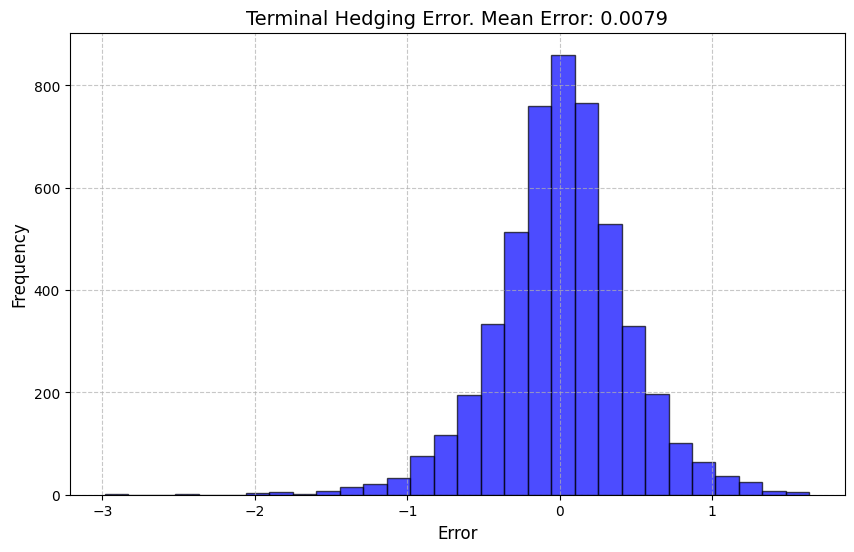

In [30]:
instrument = GBMStock(S0=100, T=50/252, N=50, r=0.05, sigma=0.2)
contingent_claim = EuropeanCall(strike=100)
cost_function = ProportionalCost(proportion=0.0)
risk_measure = CVaR(alpha=0.5)
#risk_measure = MAE()
#agent = LSTMAgent(instrument.N)
#agent = RecurrentAgent()
delta_agent = DeltaHedgingAgent(instrument, contingent_claim)
bs_price = delta_agent.get_model_price()
agent = delta_agent
#agent = RecurrentAgent(path_transformation_type=None, K = contingent_claim.strike)
#agent = LSTMAgent(instrument.N, path_transformation_type='log_moneyness', K = contingent_claim.strike)

model_path = os.path.join(os.getcwd(), 'models', agent.name, 'logm_0c_cvar50.keras')
optimizer_path = os.path.join(os.getcwd(), 'optimizers', agent.name, 'logm_0c_cvar50')


initial_learning_rate = 0.001
decay_steps = 10 
decay_rate = 0.99  
learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True 
)

env = Environment(
    agent=agent,
    instrument=instrument,
    contingent_claim=contingent_claim,
    cost_function=cost_function,
    risk_measure=risk_measure,
    n_epochs=200,
    batch_size=2_000,
    learning_rate=learning_rate_schedule,
    optimizer=tf.keras.optimizers.Adam
)

print(time.ctime())

env.load_model(model_path)
env.load_optimizer(optimizer_path, only_weights=True)

#env.train(train_paths=20_000, val_paths=2000)

#env.save_model(model_path)
#env.save_optimizer(optimizer_path)

env.terminal_hedging_error(n_paths=5000, random_seed=33, plot_error=True, fixed_price = bs_price, n_paths_for_pricing = 50_000, 
         save_plot_path=os.path.join(os.getcwd(), 'assets', 'plots', agent.name, 'hedge_error_cv50_bsprice.pdf'))

for i in range(10,20):
   env.plot_hedging_strategy(os.path.join(os.getcwd(), 'assets', 'plots', agent.name, f'plot_{i+1}.pdf'), random_seed = i + 1)

print(time.ctime())
